In [2]:
# -*- coding: utf-8 -*-
"""
Created on Sat Jun 11 10:40:39 2016

@author: vlchaplin@gmail.com
"""

import h5py
import sys
import numpy as np
from scipy import io
from math import *;


import glob
from scipy.signal import hilbert as hilbert
import scipy.signal as scisig
import matplotlib.pyplot as plt
from matplotlib import image

def abshilbert(x):
    return np.abs(hilbert(x))

sys.path.append('C:\\Users\\vchaplin\\Documents\\HiFU\\code\\myPy')  
sys.path.append('C:\\Users\\vchaplin\\Documents\\HiFU\\code\\AblationSims')
sys.path.append('C:\\Users\\Vandiver\\Documents\\HiFU\\code\\BioHeatCpp\\PBHEswig\\x64')

In [203]:
simDir="/Users/vchaplin/Data/Verasonics/PSF_simulation/runs0706cw/"
simFiles=glob.glob(simDir + "*.mat")

outH5file="/Users/vchaplin/Data/Verasonics/PSF_simulation/PSF_point_0609.h5"


#%% load template file
file="/Users/vchaplin/Data/Verasonics/PSF_simulation/runs0706cw/simulation_1000kHz_x300_y300.mat"
file="/Users/vchaplin/Data/Verasonics/PSF_simulation/runs0706cw/simulation1.1_1200kHz_x500_y300.mat"

matdict=io.loadmat(file,squeeze_me=True,struct_as_record=False)

#load data
pr_data=matdict['sensor_data'].p[:,:]
p_final=matdict['sensor_data'].p_final

Nchan=pr_data.shape[0]
Nt=pr_data.shape[1]
dt=matdict['dt']
times = np.arange(0, Nt*dt,dt)
simDims = (matdict['Nx'], matdict['Ny'] )

pointz_sim = (matdict['sourceloc'][0]-0.)*matdict['d']
pointx_sim = (matdict['sourceloc'][1]-0.)*matdict['d']


pointx = pointx_sim - (matdict['firstEll'])*matdict['d']
pointz = pointz_sim -4.5*matdict['d']

In [683]:
pointx

0.0032034999999999998

In [204]:
d = matdict['d']

pitch=matdict['pitch']*matdict['d']

c0 = np.mean(matdict['medium'].sound_speed)

#target image space
ducer_width = pitch*Nchan

dx = 2e-4
dz = 2e-4
Nx = round(ducer_width/dx)
Nz = round(8.0e-2 /dz )


#dx = d
#dz = d
#Nx = matdict['Ny']
#Nz = matdict['Nx']


xpnts = np.linspace(-0.5,0.5,Nx)*Nx*dx
zpnts = np.linspace(0,1,Nz)*Nz*dz
#sensor positions
ux = (np.linspace(-0.5,0.5,Nchan)*Nchan + 0.5)*pitch


point_zi = floor(pointz/dz)
point_xj = floor(pointx/dx)


#image and resampling grids
ndZ,ndX,ndux = np.meshgrid(zpnts,xpnts,ux, indexing='ij')

distances = np.sqrt( (ndX-ndux)**2 + ndZ**2 )
delayinds = np.round( distances / (c0*dt)).astype(int)
inbounds3 = (delayinds < Nt)
ii=np.nonzero(inbounds3)

#%% determine input sampling
PSFsourcePlacementMask = np.zeros(simDims,dtype=bool)
uniqZ = {}
uniqX = {}



# "x" in the sim file name maps to depth (z) dimension
#for fi in range(0,len(simFiles)):
#    matdict=io.loadmat(simFiles[fi],squeeze_me=True,struct_as_record=False,variable_names='sourceloc')
#    zk,xk=matdict['sourceloc'][[0,1]]
#    PSFsourcePlacementMask[zk,xk]=True
    
#    uniqZ["%d"%zk]=1
#    uniqX["%d"%xk]=1
#%% PSF

#npointsZ = len(uniqZ)
#npointsX = len(uniqX)

#large dimensionality, store as 32 bit
#PSF = np.zeros([npointsZ,npointsX,Nz,Nx],dtype=np.int32)

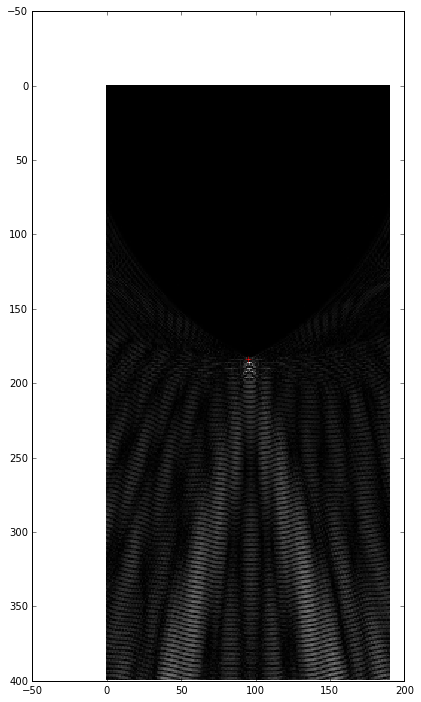

In [206]:
#%%image formation
delayed=np.zeros([Nz,Nx,Nchan])
delayed[ii[0],ii[1],ii[2]] = pr_data[ii[2], delayinds[inbounds3]]



chandelaysum = np.sum(distances*delayed,axis=2)
chandelaysum2 = np.sum( (distances*delayed)**2,axis=2) 
                
                
img = np.abs(chandelaysum)
#img = np.abs(chandelaysum2)
#img = abshilbert(chandelaysum)
mr,mc = np.meshgrid(range(img.shape[0]), range(img.shape[1]), indexing='ij')
#mask= np.abs(mr-200)<15
#(z0i,x0j) = np.unravel_index(np.argmax(img*mask),img.shape)
(z0i,x0j) = (point_zi, point_xj)
#%%plot
plt.figure(figsize=(12,12))
ext=[xpnts[0],xpnts[-1],zpnts[-1],zpnts[0]]
plt.imshow( img,cmap=image.cm.gray,interpolation='None')
plt.plot( [x0j], [z0i], 'r+')

In [193]:
img10 = img.copy()

In [207]:

PSFarray = img.copy()
def PSFij(z,x):
    row = np.floor( z/dz + z0i ).astype(int)
    col = np.floor( x/dx + x0j ).astype(int)
    
    return (row,col)

def PSF(z,x):
    (row,col) = PSFij(z,x)
    #if row<0 or row>=Nz:
    #    return 0
    #if col<0 or col>=Nx:
    #    return 0
    
    return PSFarray[row,col]
     


In [348]:
PSFij(0.01,0.01)

(319, 225)

In [624]:
PSFarray.shape

(400, 191)

In [179]:
blankarray = np.zeros([200, 100])
blankarray[50,10]=1
blankarray[120,40]=1

In [180]:
res = scisig.convolve2d(blankarray, PSFarray,mode='same')

In [181]:
res.shape

(200, 100)

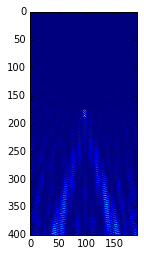

In [18]:
plt.imshow(PSFarray)

## Load PAM reconstruction (HDF5)

In [20]:
import h5py

def makename(case,power,probe,probestr=None):
    if probestr is None:
        probestr="probe%d"%probe
    
    return "%s/%s_%dW/%s"%(case,case,power,probestr)

def loadmaps( case,power, acqlist=None,h5f=f, timeavg=True):
    
        base=makename(case,power, 0)
    
        (nf,na,nz,nx)=h5f[base+'/cross'].shape
        Moment1Imgf=h5f[base+'/mom1'].value.reshape([2,nf*na,nz,nx])
        Moment2Imgf=h5f[base+'/mom2'].value.reshape([2,nf*na,nz,nx])
        ProbeCrossTerm = h5f[base+'/cross'].value.reshape([nf*na,nz,nx])
        
        if acqlist is None:
            varianceImage1 = Moment1Imgf[0]**2 - Moment2Imgf[0]
            varianceImage2 = Moment1Imgf[1]**2 - Moment2Imgf[1]
            coherenceTerm = 2*ProbeCrossTerm
        else:
            varianceImage1 = Moment1Imgf[0,acqlist]**2 - Moment2Imgf[0,acqlist]
            varianceImage2 = Moment1Imgf[1,acqlist]**2 - Moment2Imgf[1,acqlist]
            coherenceTerm = 2*ProbeCrossTerm[acqlist]
        if timeavg:
            varianceImage1 = np.mean(varianceImage1,axis=(0)) 
            varianceImage2 = np.mean(varianceImage2,axis=(0)) 
            coherenceTerm = np.mean(coherenceTerm,axis=(0)) 
            
        return (varianceImage1,varianceImage2,coherenceTerm)

In [19]:
hfile='/Users/Vandiver/Data/Verasonics/sonalleve_20160803/CoupledRecon_Chicken_20160803.h5'

hfile='/Users/Vandiver/Data/Verasonics/sonalleve_20160803/CoupledRecon_Phant_20160803.h5'

f = h5py.File(hfile,'r')

In [549]:
list(f.keys())

['multi_1', 'multi_2', 'single']

In [287]:
f.close()

In [117]:
(varianceImage1,varianceImage2,coherenceTerm) = loadmaps("multi_2",60,h5f=f,timeavg=True)

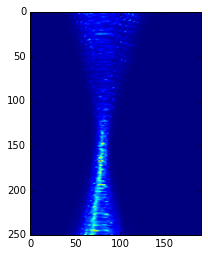

In [67]:
plt.imshow(varianceImage1 + varianceImage2)

### Richardson-Lucy

In [208]:
gz,gx=np.meshgrid(np.arange(-0.015,0.015,dz), np.arange(-0.01,0.01,dx), indexing='ij')
psf_h = PSF(gz,gx) 
psf_hconj = PSF(-gz,-gx)

psf2 = psf_hconj
psf2_hconj = psf_h

psf_h.shape

(150, 100)

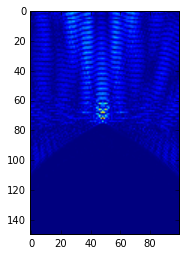

In [209]:

plt.imshow(psf_hconj)

In [210]:
#vanilla
fn = varianceImage1.copy()
#fn = varianceImage1 + varianceImage2
fnset=[]

for i in range(0,7):
    res = scisig.convolve2d(fn, psf_h,mode='same')
    fn1 = fn*scisig.convolve2d(fn/res, psf_hconj, mode='same')
    fnset.append(fn1)
    
    print((i, np.sum(np.abs(fn1 - fn))/np.sum(fn)) )
    fn=fn1

(0, 0.60364119564583696)
(1, 0.59809575402104898)
(2, 0.60816283185294018)
(3, 0.62190376612754694)
(4, 0.62517693591508594)
(5, 0.63638956324097395)
(6, 0.65141465625145079)


In [211]:
#vanilla
fn = varianceImage2.copy()
#fn = varianceImage1 + varianceImage2
fnset2=[]


for i in range(0,7):
    res = scisig.convolve2d(fn, psf2,mode='same')
    fn1 = fn*scisig.convolve2d(fn/res, psf2_hconj, mode='same')
    fnset2.append(fn1)
    
    print((i, np.sum(np.abs(fn1 - fn))/np.sum(fn)) )
    fn=fn1

(0, 0.55193003818642106)
(1, 0.53292986210314874)
(2, 0.52028432321091544)
(3, 0.52557188764994855)
(4, 0.54869993479755275)
(5, 0.58249590228703529)
(6, 0.60442621207886715)


In [175]:
#with regularizaiton
fregN = varianceImage1.copy()

lambda_factor = 0.002

fregset=[]
for i in range(0,8):
    
    res = scisig.convolve2d(fregN, psf_h,mode='same')
    
    gradx,grady=np.gradient(fregN)    
    gradMag = np.sqrt( gradx**2 + grady**2 ) 
    
    
    if np.min(gradMag) < 1e-16:
        print("gradient essentially zero in some places")
        #break
    
    #divergence terms
    dxx,dxy=np.gradient(gradx/gradMag)
    dyy,dyx=np.gradient(grady/gradMag)
    
    regularization_factor = 1.0 / ( 1- lambda_factor*(dxx+dyy))
    
    fn1 = fregN*scisig.convolve2d(fregN/res, psf_hconj, mode='same') * regularization_factor
    fregset.append(fn1)
    
    
    print((i, np.sum(np.abs(fn1 - fregN))/np.sum(fregN)) )
    fregN=fn1
    
    



(0, 0.36571808672135447)
(1, 0.37138182005985165)
(2, 0.36071759044922125)
(3, 0.35723859790999696)
(4, 0.36935214027520868)
(5, 0.39402574224284787)
gradient essentially zero in some places
(6, 0.42289473891015128)
gradient essentially zero in some places
(7, 0.42932095831907602)


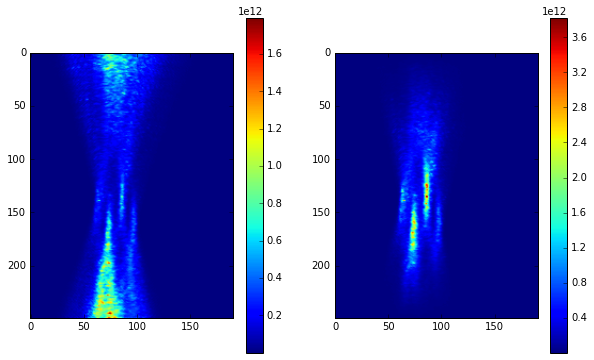

In [217]:
rix=1
fig=plt.figure(figsize=(10,6))
ax1=fig.add_subplot(121)
im1=ax1.imshow( varianceImage1 + varianceImage2  )
plt.colorbar(mappable=im1)
ax2=fig.add_subplot(122)
im2=ax2.imshow(fnset[rix] + fnset2[rix])
plt.colorbar(mappable=im2)

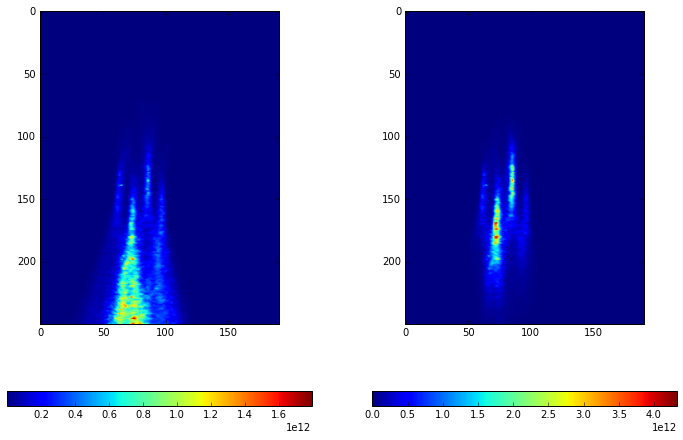

In [180]:
fig=plt.figure(figsize=(12,8))
ax1=fig.add_subplot(121)
im1=ax1.imshow(varianceImage1)
plt.colorbar(mappable=im1,orientation='horizontal')
ax2=fig.add_subplot(122)
im2=ax2.imshow(fregset[2])
plt.colorbar(mappable=im2,orientation='horizontal')

In [374]:
np.mean(varianceImage1)

42957802081.280563

In [373]:
np.mean(fnset[1])

45138200457.380402